<div class="alert alert-block alert-danger">
<b><center> Simple_CNN:</b><center>AUG(100) + batch_norm + 20 epochs.
</div>

In [17]:
import PIL
import torch

import pickle
import numpy as np
import pandas as pd 
from sklearn.metrics import f1_score
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import zipfile

from IPython.display import Image
!chcp 65001

Active code page: 65001


In [2]:
PIL.__version__, torch.__version__

('9.2.0', '1.12.1+cu116')

In [3]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [581]:
%%time
with zipfile.ZipFile("journey-springfield.zip", "r") as zif_ref:
    zif_ref.extractall("Data_unzip")

Wall time: 33.6 s


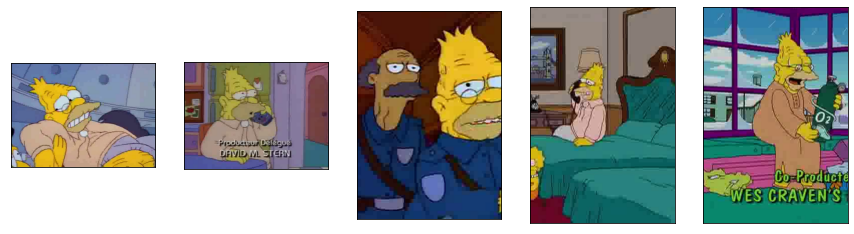

In [4]:
from PIL import Image

fig, ax = plt.subplots(1,5, figsize = (15,10))
for i in range(5):
    #img = Image("pic_000{}.jpg".format(i), width=100, height=100)
    img = Image.open("Data_unzip/train/simpsons_dataset/abraham_grampa_simpson/pic_000{}.jpg".format(i))
    ax[i].imshow(img)
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

In [5]:
TRAIN_DIR = Path('Data_unzip/train/simpsons_dataset')
TEST_DIR = Path('Data_unzip/testset/testset')

In [6]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. 

Вам стоит понимать, что происходит с $LabelEncoder$ и  с $torch.Transformation$. 

ToTensor конвертирует  $PIL$_$Image$ с параметрами в диапазоне $[0, 255]$ (как все пиксели) в $FloatTensor$ размера $(C x H x W)$ $[0,1]$ , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [8]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.idx = None

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            self.idx = self.label_encoder.transform(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    #h,w,c
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
from sklearn.model_selection import train_test_split
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
def generate_aug(train_dataset):
    df = pd.DataFrame()
    df['name'] = train_dataset.labels
    df['Id'] = train_dataset.idx
    table = df['Id'].value_counts()
    
    I = []
    nn = []
    A = 0
    L = []
    OST = []
    for i in range(len(train_dataset.idx)):
        if(table[train_dataset.idx[i]]<100):
            #Зашли первый раз!
            A = A+1
            if(A==1): 
                tmp = train_dataset.labels[i]
                nn.append(train_dataset.files[i])
                L.append(train_dataset.idx[i])
            if(A>1):
                if(tmp == train_dataset.labels[i]):
                    nn.append(train_dataset.files[i])
                    if((tmp == 'troy_mcclure') and (len(nn)==6)):
                        I.append(nn)

                else:
                    I.append(nn)
                    nn = [train_dataset.files[i]]
                    tmp = train_dataset.labels[i]
                    L.append(train_dataset.idx[i])
        else:
            OST.append(train_dataset.files[i])
        
    s = 0
    for i in range(len(I)):
        s += len(I[i])

    if(s!=904):
        print("Ошибка ! Не хватает ссылок на картинки !")
        return None
    
    else:
        for i in range(len(I)):
            I[i] += list(np.random.choice(I[i], size = 100-len(I[i])))
        
        Z = [num for elem in I for num in elem]
        end = OST+Z
        return end 


val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')
train_aug_dataset = SimpsonsDataset(generate_aug(train_dataset), mode='train')

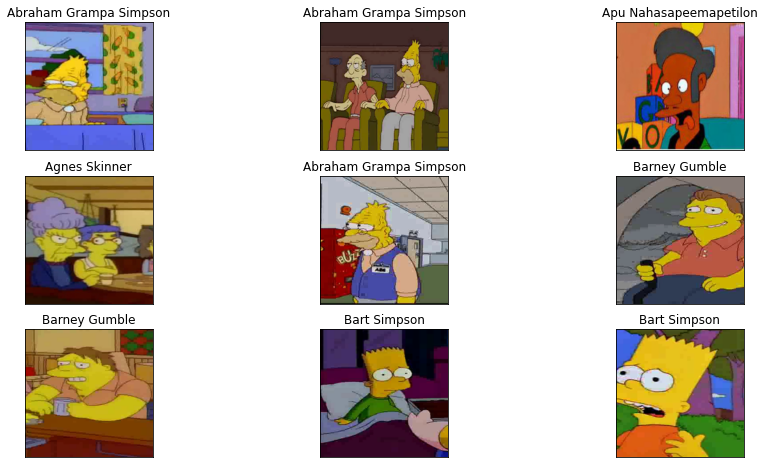

In [12]:
##Чуть чуть отобразим валидацию!

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = np.random.randint(0,1000)
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    fig_x.get_xaxis().set_visible(False)
    fig_x.get_yaxis().set_visible(False)

In [13]:
#Сдеаем веса для random_weights_sampler
def weights_in_dataset(train_dataset):
    df = pd.DataFrame()
    df['name'] = train_dataset.labels
    df['Id'] = train_dataset.idx
    table = pd.DataFrame(df['Id'].value_counts())
    table['name'] = train_dataset.label_encoder.inverse_transform(table.index.values)

    train_counts = table
    weights = 1./train_counts.Id
    weights_in_dataset = [weights[i] for i in train_dataset.idx]
    return weights_in_dataset

weights = weights_in_dataset(train_dataset)

In [14]:
#Сделаем 3 дата лоудера

batch_size = 4
sampler_weighs =  torch.utils.data.WeightedRandomSampler(weights, len(weights))

train_loader_weighs = DataLoader(train_dataset, batch_size=batch_size, sampler = sampler_weighs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
train_loader_aug = DataLoader(train_aug_dataset, batch_size=batch_size, shuffle = True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle = True)

In [15]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [16]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, paddi

In [20]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    
    scheduler.step()         
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


def train(train_loader, val_loader, model, epochs):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, exp_lr_scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history


def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [22]:
%%time
from PIL import Image
history = train(train_loader_aug, val_loader, model=simple_cnn, epochs=1)

epoch:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

loss 1.9139360204960827


epoch: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [05:41<00:00, 341.35s/it]


Epoch 001 train_loss: 1.9139     val_loss 1.2997 train_acc 0.5141 val_acc 0.6699
Wall time: 5min 41s


In [603]:
#Сохраним веса модели Simple_CNN
PATH = "CNN_weights/weights_CNN.pt"
#Save:
torch.save(simple_cnn.state_dict(), PATH)

In [615]:
from PIL import Image
#Сделаем сабмит на кегл
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=4)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [622]:
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('simpsons_simple_cnn_baseline.csv', index=False)

<div class="alert alert-block alert-danger">
<b><center> Kaggle:</b><center>Получили score = 0.94261.
</div>

<center >Попробуем теперь использовать VGG с предтрейном!

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 2)